In [2]:
import math

import matplotlib.pyplot as plt
import numpy as np
import torch

from vjf.model import VJF

import h5py
from einops import rearrange

import sys
sys.path.append("../")

from code_pack.generate_vdp_data import generate_van_der_pol, generate_noisy_van_der_pol

def grid(n, lims):
    xedges = np.linspace(*lims, n)
    yedges = np.linspace(*lims, n)
    X, Y = np.meshgrid(xedges, yedges)
    grids = np.column_stack([X.reshape(-1), Y.reshape(-1)])
    return X, Y, grids


In [ ]:
# Setup precision and random seeds
torch.set_default_dtype(torch.double)  # using double precision
np.random.seed(0)
torch.manual_seed(0)

In [3]:
delta = 5e-3  # time bin size
n_trials = 1
bin_size_ms = 5
time_delta = bin_size_ms * 1e-3

for trial in range(n_trials):
    if trial < n_trials//2:
        state00 = np.random.uniform(-0.5, 0.5)
        state01 = np.random.uniform(-0.5, 0.5)
    else:
        state00 = np.random.uniform(-1.0, 1.0)
        state01 = np.random.uniform(-1.0, 1.0)

    state0 = (state00, state01)
    
system_parameters = {}
system_parameters['mu'] = 1.5
system_parameters['tau_1'] = 0.1
system_parameters['tau_2'] = 0.1
system_parameters['sigma'] = 0.1  # noise add into euler integration
system_parameters['scale'] = 1 / 0.4

In [4]:
#generate latent
n_time_bins = 2000
t = delta * torch.arange(n_time_bins)
X = generate_noisy_van_der_pol(state0, t, system_parameters)

n_latents = X.shape[-1]
n_neurons = 50
X = X.reshape((n_time_bins, n_latents)) #n_trials>1?

#scale for same snr
X = X @ np.array([[4,0],[0,4]])

In [5]:
#generate observations Guassian observations
C = np.random.normal(size=(n_latents, n_neurons))  # loading matrix
d = np.random.normal(size=n_neurons)  # bias
# observation
Y = X @ C + d
Y = Y + np.random.normal(size=Y.shape) * 0.1  # add some noise

In [ ]:
# Setup and fit VJF 
n_rbf = 50  # number of radial basis functions for dynamical system
hidden_sizes = [20]  # size of hidden layers of recognition model
udim = 0
likelihood = 'gaussian'  # gaussian or poisson

model_gauss = VJF.make_model(n_neurons, n_latents, udim=udim, n_rbf=n_rbf, hidden_sizes=hidden_sizes, likelihood=likelihood)

m_gauss, logvar, _ = model_gauss.fit(Y, max_iter=150)  # fit and return list of state posterior tuples (mean, log variance)

m_gauss = m_gauss.detach().numpy().squeeze()

In [ ]:
# regress to account for invariance
X_hat = m_gauss #rearrange(m_vdp, 'batch time lat ->  (batch time) lat')
S = np.linalg.pinv(X_hat) @ X.reshape(n_trials * n_time_bins, n_latents)
X_hat_tilde = X_hat @ S
X_hat_tilde = X_hat_tilde.reshape(n_trials, n_time_bins, n_latents)

# Plot
fig, axs = plt.subplots(2, 1, sharex='all')
print(f'X_hat shape: {X_hat.shape}')
axs[0].plot(X[:, 0])
axs[0].plot(X_hat_tilde[trial, :, 0])

axs[1].plot(X[:, 1])
axs[1].plot(X_hat_tilde[trial, :, 1])
plt.legend(["Data", "Fit"])
plt.show()

In [ ]:
# Draw the inferred velocity field

ax = fig.add_subplot(223)
r = np.mean(np.abs(m_gauss).max())  # determine the limits of plot

Xm, Ym, XYm = grid(51, [-1.5*r, 1.5*r])
Um, Vm = model_gauss.transition.velocity(torch.tensor(XYm, dtype=torch.float)).detach().numpy().T  # get velocity
Um = np.reshape(Um, Xm.shape)
Vm = np.reshape(Vm, Ym.shape)
plt.streamplot(Xm, Ym, Um, Vm)
plt.plot(*m_gauss.T, color='C1', alpha=0.5, zorder=5)
plt.title('Velocity field')

### Poisson

In [15]:
#generate Poisson observations: spikes
C = np.random.normal(size=(n_neurons, n_latents))
max_c = .8
C = np.where(np.abs(C)>max_c, np.sign(C)*max_c, C)
C = 1.*C
b = np.log(0.5 + 0.05 * np.random.rand(n_neurons))  # 10 to 60 hz baseline
rates = np.exp(X@C.T + b)
r = delta * rates

Y_unchopped = np.random.poisson(r) 
Y = np.where(Y_unchopped>1, 1, Y_unchopped)

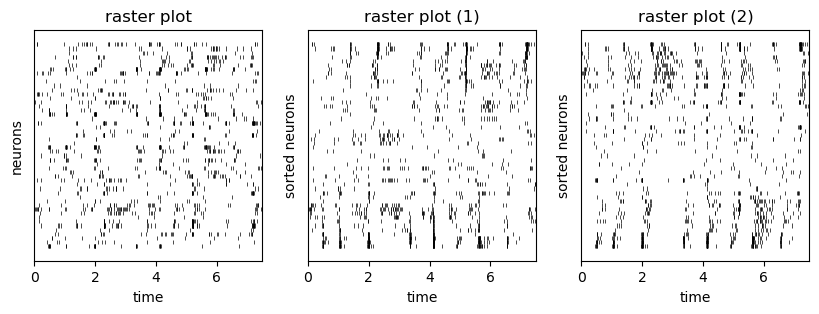

In [16]:
cidx1 = np.lexsort((C[:,0], C[:,1]), axis=0)
cidx2 = np.lexsort((C[:,1], C[:,0]), axis=0)

nT = 1500
T = time_delta*nT

raster = []; rasterSorted1 = []; rasterSorted2 = []
for k in range(n_neurons):
    raster.append(np.nonzero(Y[:,k])[0]/nT*T)
    rasterSorted1.append(np.nonzero(Y[:,cidx1[k]])[0]/nT*T)
    rasterSorted2.append(np.nonzero(Y[:,cidx2[k]])[0]/nT*T)
    
plt.subplots(1,3, figsize=(10, 3))
plt.subplot(1,3,1)
plt.eventplot(raster, lw=0.5, color='k', label='spikes')
plt.xlim(0, T); plt.xlabel('time'); plt.yticks([]); plt.title('raster plot'); plt.ylabel('neurons');
plt.subplot(1,3,2)
plt.eventplot(rasterSorted1, lw=0.5, color='k', label='spikes')
plt.xlim(0, T); plt.xlabel('time'); plt.yticks([]); plt.title('raster plot (1)'); plt.ylabel('sorted neurons');
plt.subplot(1,3,3)
plt.eventplot(rasterSorted2, lw=0.5, color='k', label='spikes')
plt.xlim(0, T); plt.xlabel('time'); plt.yticks([]); plt.title('raster plot (2)'); plt.ylabel('sorted neurons');

In [17]:
# Setup and fit VJF 
n_rbf = 150  # number of radial basis functions for dynamical system
hidden_sizes = [20]  # size of hidden layers of recognition model
udim = 0
likelihood = 'poisson'  # gaussian or poisson

model_poisson = VJF.make_model(n_neurons, n_latents, udim=udim, n_rbf=n_rbf, hidden_sizes=hidden_sizes, likelihood=likelihood)

m_poisson, logvar, _ = model_poisson.fit(Y, max_iter=250)  # fit and return list of state posterior tuples (mean, log variance)

m_poisson = m_poisson.detach().numpy().squeeze()

100%|███████████████████████████████████████████████████████████████████| 250/250 [1:21:13<00:00, 19.50s/it, Loss=9.85]


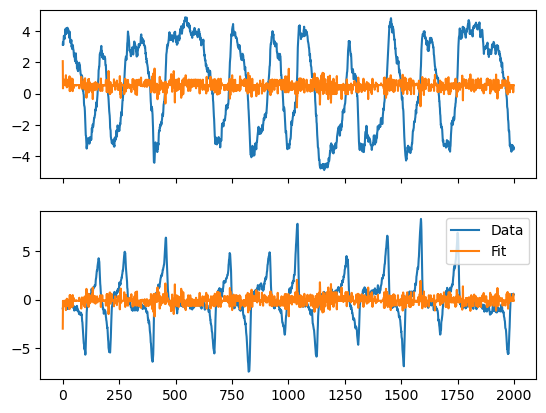

In [18]:
# regress to account for invariance
X_hat = m_poisson 
S = np.linalg.pinv(X_hat) @ X.reshape(n_trials * n_time_bins, n_latents)
X_hat_tilde = X_hat @ S
X_hat_tilde = X_hat_tilde.reshape(n_trials, n_time_bins, n_latents)

# Plot
fig, axs = plt.subplots(2, 1, sharex='all')
axs[0].plot(X[:, 0])
axs[0].plot(X_hat_tilde[trial, :, 0])

axs[1].plot(X[:, 1])
axs[1].plot(X_hat_tilde[trial, :, 1])
plt.legend(["Data", "Fit"])
plt.show()

Text(0.5, 1.0, 'Velocity field')

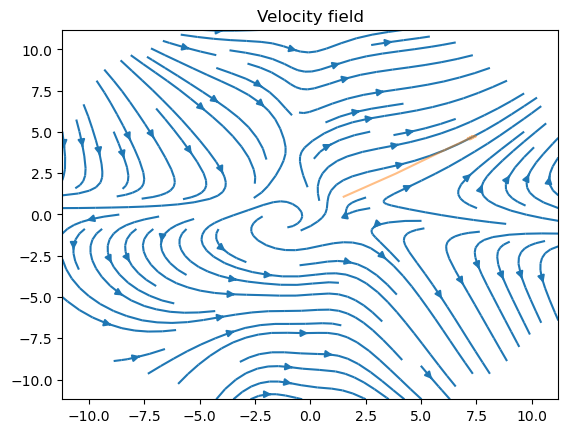

In [19]:
# Draw the inferred velocity field

ax = fig.add_subplot(223)
r = np.mean(np.abs(m_poisson).max())  # determine the limits of plot

Xm, Ym, XYm = grid(51, [-1.5*r, 1.5*r])
Um, Vm = model_poisson.transition.velocity(torch.tensor(XYm, dtype=torch.float)).detach().numpy().T  # get velocity
Um = np.reshape(Um, Xm.shape)
Vm = np.reshape(Vm, Ym.shape)
plt.streamplot(Xm, Ym, Um, Vm)
plt.plot(*m_poisson.T, color='C1', alpha=0.5, zorder=5)
plt.title('Velocity field')